In [25]:
import numpy as np

# Constants for dimensions
BATCH, SEQ, HEADS, DEPTH = 0, 1, 2, 3

def softmax(x, axis=-1):
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

def multi_head_attention(Q, K, V, num_heads):
    batch_size, seq_len, d_model = Q.shape
    assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
    depth = d_model // num_heads

    # 1) Linear projections for Q, K, V
    W_q = np.random.randn(d_model, d_model)
    W_k = np.random.randn(d_model, d_model)
    W_v = np.random.randn(d_model, d_model)
    W_o = np.random.randn(d_model, d_model)

    Q_proj = Q @ W_q    # (batch, seq_len, d_model)
    K_proj = K @ W_k
    V_proj = V @ W_v

    # 2) Split heads
    def split_heads(x):
        # TODO: reshape x to (batch, num_heads, seq_len, depth)
        batch_size, seq_len, d_model = x.shape
        depth = d_model // num_heads
        x = x.reshape(batch_size, num_heads, seq_len, depth)  # (batch, heads, seq_len, depth)
        return x  # transpose 불필요

    Qh = split_heads(Q_proj)
    Kh = split_heads(K_proj)
    Vh = split_heads(V_proj)

    # 3) Scaled Dot-Product Attention per head
    scores = Qh @ Kh.transpose(0, 1, 3, 2)  # (batch, heads, seq_len, seq_len)
    scores /= np.sqrt(depth)
    weights = softmax(scores, axis=-1)     # (batch, heads, seq_len, seq_len)
    head_out = weights @ Vh                # (batch, heads, seq_len, depth)

    # 4) Concatenate heads
    def combine_heads(x):
        # TODO: reshape x back to (batch, seq_len, d_model)
        batch_size, num_heads, seq_len, depth = x.shape
        x = x.transpose(0, 2, 1, 3)  # (batch, seq_len, heads, depth)
        x = x.reshape(batch_size, seq_len, num_heads * depth)  # (batch, seq_len, d_model)
        return x

    concat = combine_heads(head_out)

    # 5) Final linear projection
    output = concat @ W_o                # (batch, seq_len, d_model)
    return output, weights


In [26]:
# Usage example
if __name__ == "__main__":
    batch, seq_len, d_model, heads = 1, 6, 16, 4
    Q = np.random.randn(batch, seq_len, d_model)
    K = np.random.randn(batch, seq_len, d_model)
    V = np.random.randn(batch, seq_len, d_model)

    out, attn_weights = multi_head_attention(Q, K, V, heads)
    print("Output shape:", out.shape)
    print("Attention weights shape:", attn_weights.shape)


Output shape: (1, 6, 16)
Attention weights shape: (1, 4, 6, 6)


### Head 0 하나만 시각화

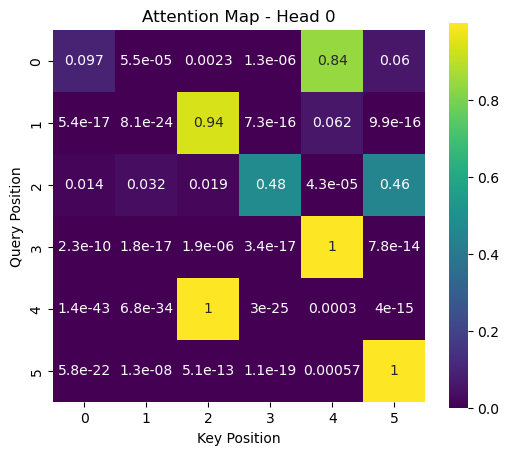

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# 첫 번째 Head의 Attention Map
head_idx = 0
attn_map = attn_weights[0, head_idx]  # shape: (6, 6)

plt.figure(figsize=(6, 5))
sns.heatmap(attn_map, annot=True, cmap='viridis', square=True)
plt.title(f"Attention Map - Head {head_idx}")
plt.xlabel("Key Position")
plt.ylabel("Query Position")
plt.show()


### 모든 Head 한눈에 보기

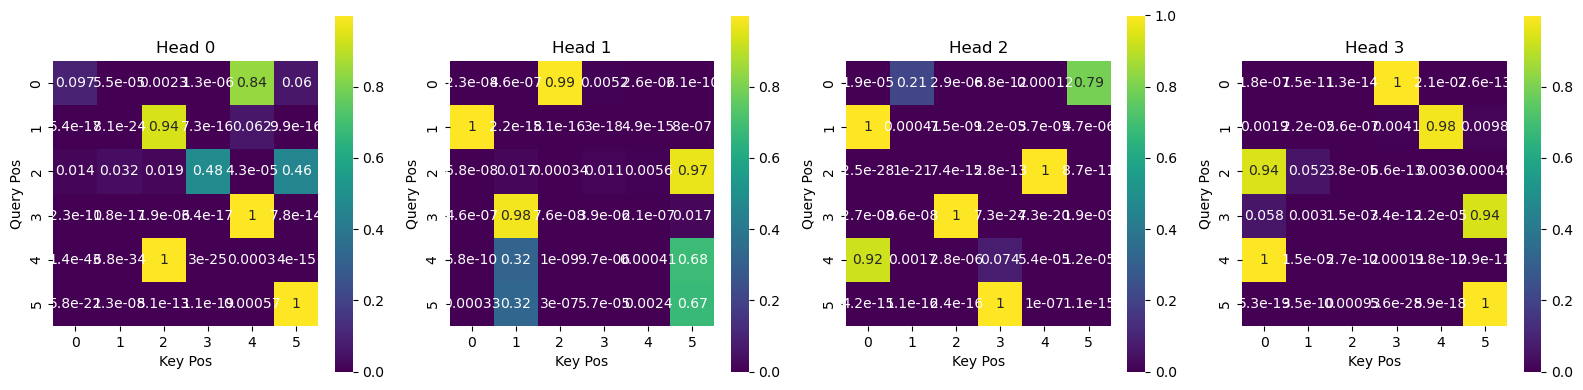

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

num_heads = attn_weights.shape[1]
fig, axes = plt.subplots(1, num_heads, figsize=(4 * num_heads, 4))

for i in range(num_heads):
    ax = axes[i]
    sns.heatmap(attn_weights[0, i], annot=True, cmap='viridis', square=True, ax=ax)
    ax.set_title(f"Head {i}")
    ax.set_xlabel("Key Pos")
    ax.set_ylabel("Query Pos")

plt.tight_layout()
plt.show()


### Multi-Head Attention 구조 흐름

In [ ]:
'''
입력 문장 (토큰 임베딩)
   ↓
선형 변환 (Wᵢᵠ, Wᵢᵏ, Wᵢᵛ)
   ↓
Head 분리
 ┌──────────────┐
 │ Head 1       │ → Attention(Q₁, K₁, V₁)
 │ Head 2       │ → Attention(Q₂, K₂, V₂)
 │  ...         │
 │ Head h       │ → Attention(Qₕ, Kₕ, Vₕ)
 └──────────────┘
   ↓
Concat(head₁~h)
   ↓
선형 변환 (Wᵒ)
   ↓
출력 (batch, seq_len, d_model)
'''